In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/open-food-facts/en.openfoodfacts.org.products_out.csv
/kaggle/input/open-food-facts/processed_openfoodfacts_dataset.csv
/kaggle/input/open-food-facts/en.openfoodfacts.org.products.csv


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("OpenFoodFacts").getOrCreate()

In [3]:
working_dir=os.getcwd()
working_dir

'/kaggle/working'

In [4]:
# Define file paths
file_paths = ["/kaggle/input/open-food-facts/en.openfoodfacts.org.products_out.csv",
              "/kaggle/input/open-food-facts/en.openfoodfacts.org.products.csv"]

# Load CSVs and print column names
for file in file_paths:
    print(f"Columns in {file}:")
    df = spark.read.csv(file, header=True, inferSchema=True)
    print(df.columns)
    print("-" * 80)

Columns in /kaggle/input/open-food-facts/en.openfoodfacts.org.products_out.csv:
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'ingredients_tags', 'ingredients_analysis_tags', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutrition_data', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_grad

In [5]:
# Load the tab-separated file
tsv_file =file_paths[1]
csv_file = f"{working_dir}/en.openfoodfacts.org.products.csv"
df = spark.read.option("delimiter", "\t").option("header", "true").csv(tsv_file)

In [6]:
# Save as CSV
df.coalesce(1).write.option("header", "true").csv(csv_file, mode="overwrite")
print("Conversion completed!")

Conversion completed!


In [7]:
import glob

csv_file_path=glob.glob(f"{csv_file}/*.csv")[0]
csv_file_path

'/kaggle/working/en.openfoodfacts.org.products.csv/part-00000-405f9d55-c50f-4bcf-83fb-79376c59b9e9-c000.csv'

In [8]:
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [9]:
# Select relevant columns for predicting Nutri-Score grade
feature_columns  = [
    'nutriscore_grade',  # Target variable
    'energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
    'proteins_100g', 'salt_100g', 'fiber_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
    'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g'
]
feature_columns

['nutriscore_grade',
 'energy-kj_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'fiber_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition-score-fr_100g']

In [10]:
df = df.select(feature_columns)

In [11]:
# Drop rows with missing values in the target variable
df = df.na.drop(subset=["nutriscore_grade"])

In [12]:
from pyspark.sql.functions import col, lit,col, isnan, sum as sum_
from pyspark.sql.types import DoubleType

# Select all feature columns except the target column
feature_columns = [c for c in df.columns if c != "nutriscore_grade"]

# Select all columns, keeping the target column as is and converting others to DoubleType
df = df.select(
    col("nutriscore_grade"),  # Keep target column as is
    *[col(c).cast(DoubleType()).alias(c) for c in feature_columns]  # Convert features to DoubleType
)

In [13]:
df.printSchema()

root
 |-- nutriscore_grade: string (nullable = true)
 |-- energy-kj_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- carbohydrates_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- fiber_100g: double (nullable = true)
 |-- sodium_100g: double (nullable = true)
 |-- vitamin-a_100g: double (nullable = true)
 |-- vitamin-c_100g: double (nullable = true)
 |-- calcium_100g: double (nullable = true)
 |-- iron_100g: double (nullable = true)
 |-- nutrition-score-fr_100g: double (nullable = true)



In [14]:
from pyspark.ml.feature import Imputer

# Define the Imputer to fill missing values with the mean
feature_columns = [col for col in df.columns if col != "nutriscore_grade"]
imputer = Imputer(inputCols=feature_columns, outputCols=feature_columns, strategy="mean")
df = imputer.fit(df).transform(df)

In [15]:
null_counts = df.select(*[(col(c).isNull() | isnan(c)).cast("int").alias(c) for c in feature_columns])
null_counts_agg = null_counts.agg(*[sum_(col(c)).alias(c) for c in feature_columns])
null_counts_agg.show(truncate=False)

+--------------+--------+------------------+------------------+-----------+-------------+---------+----------+-----------+--------------+--------------+------------+---------+-----------------------+
|energy-kj_100g|fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|fiber_100g|sodium_100g|vitamin-a_100g|vitamin-c_100g|calcium_100g|iron_100g|nutrition-score-fr_100g|
+--------------+--------+------------------+------------------+-----------+-------------+---------+----------+-----------+--------------+--------------+------------+---------+-----------------------+
|0             |0       |0                 |0                 |0          |0            |0        |0         |0          |0             |0             |0           |0        |0                      |
+--------------+--------+------------------+------------------+-----------+-------------+---------+----------+-----------+--------------+--------------+------------+---------+-----------------------+


In [16]:
# Count the number of null values in the "nutriscore_grade" column
null_count = df.filter(df["nutriscore_grade"].isNull()).count()
print(f"Null values in nutriscore_grade column: {null_count}")

Null values in nutriscore_grade column: 0


In [17]:
from pyspark.ml.feature import StringIndexer

# Encode the target variable (nutriscore_grade) to numerical labels
indexer = StringIndexer(inputCol="nutriscore_grade", outputCol="label")
df = indexer.fit(df).transform(df)

In [18]:
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [19]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [20]:
train_data.count()

727144

In [21]:
test_data.count()

181665

In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Define the model (Random Forest Classifier)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [23]:
model = pipeline.fit(train_data)

In [24]:
# Make predictions
predictions = model.transform(test_data)

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


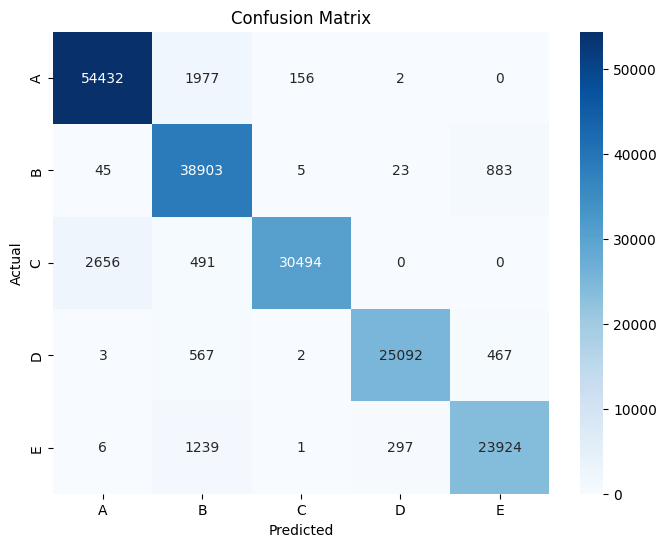

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to Pandas DataFrame for visualization
predictions_pd = predictions.select("label", "prediction").toPandas()

# Visualization 1: Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "B", "C", "D", "E"], yticklabels=["A", "B", "C", "D", "E"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

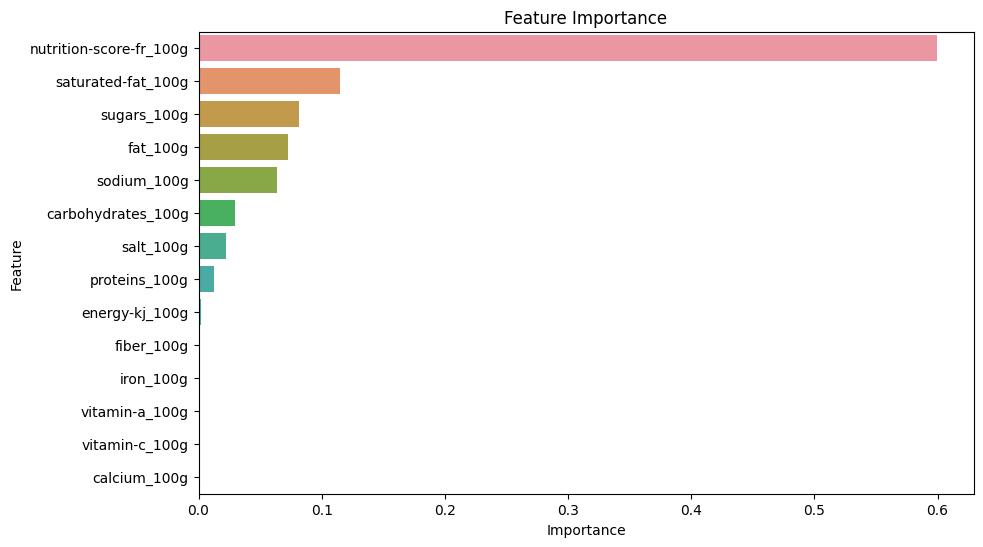

In [27]:
# Visualization 2: Feature Importance
feature_importance = model.stages[-1].featureImportances.toArray()
feature_names = feature_columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.show()

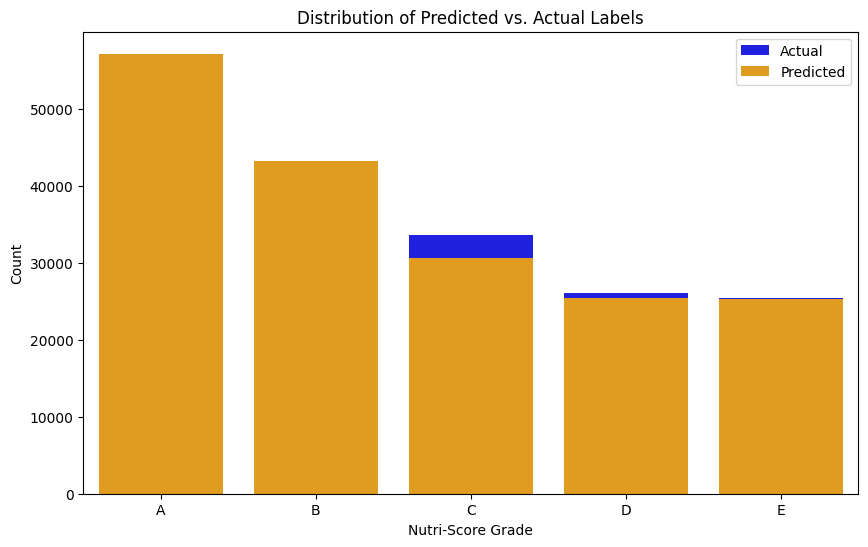

In [28]:
# Visualization 3: Distribution of Predicted vs. Actual Labels
plt.figure(figsize=(10, 6))
sns.countplot(x="label", data=predictions_pd, color="blue", label="Actual")
sns.countplot(x="prediction", data=predictions_pd, color="orange", label="Predicted")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["A", "B", "C", "D", "E"])
plt.xlabel("Nutri-Score Grade")
plt.ylabel("Count")
plt.title("Distribution of Predicted vs. Actual Labels")
plt.legend()
plt.show()